# Sompo - Previsão de Acidentes (LSTM)

**Target escolhido:** classificação binária `severo` (1 = acidentes com mortos ou feridos graves).
**Granularidade temporal:** semanal (agregação por semana e por UF).

Octavio Augusto Ramalho Brandão Pires RM: 555696

Guilherme Santos de Almeida RM: 563972

## 1) Imports e carregamento dos dados

In [16]:
import os

for root, dirs, files in os.walk('.'):
    for f in files:
        if 'acidentes2025' in f.lower():
            print(os.path.join(root, f))


./acidentes2025_todas_causas_tipos.csv


In [18]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path

# --- CAMINHO CORRETO DO ARQUIVO ---
DATA_PATH = './acidentes2025_todas_causas_tipos.csv'

# --- ETAPA 1: Carrega o CSV (com codificação correta) ---
df = pd.read_csv(DATA_PATH, sep=';', encoding='latin1')

# --- ETAPA 2: Converte a coluna de data (se existir) ---
if 'data_inversa' in df.columns:
    df['data_inversa'] = pd.to_datetime(df['data_inversa'], dayfirst=True, errors='coerce')

# --- EXIBE AS PRIMEIRAS LINHAS E INFO ---
print(df.shape)
print(df.columns)
df.head()





(427227, 37)
Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo', 'id_veiculo', 'tipo_veiculo', 'marca',
       'ano_fabricacao_veiculo', 'tipo_envolvido', 'estado_fisico', 'idade',
       'sexo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos',
       'latitude', 'longitude', 'regional', 'delegacia', 'uop'],
      dtype='object')


,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,652468,1467636.0,2025-01-01,quarta-feira,00:30:00,PE,101.0,"89,5",JABOATAO DOS GUARARAPES,Sim,...,Não Informado,0.0,0.0,0.0,0.0,"-8,20760697","-34,98372005",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
1,652468,1467635.0,2025-01-01,quarta-feira,00:30:00,PE,101.0,"89,5",JABOATAO DOS GUARARAPES,Sim,...,Feminino,0.0,1.0,0.0,0.0,"-8,20760697","-34,98372005",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
2,652468,1467634.0,2025-01-01,quarta-feira,00:30:00,PE,101.0,"89,5",JABOATAO DOS GUARARAPES,Sim,...,Masculino,0.0,1.0,0.0,0.0,"-8,20760697","-34,98372005",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
3,652468,1467637.0,2025-01-01,quarta-feira,00:30:00,PE,101.0,"89,5",JABOATAO DOS GUARARAPES,Sim,...,Não Informado,0.0,0.0,0.0,0.0,"-8,20760697","-34,98372005",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
4,652469,1467628.0,2025-01-01,quarta-feira,00:50:00,SC,101.0,120,ITAJAI,Sim,...,Feminino,0.0,1.0,0.0,0.0,"-26,912758","-48,711998",SPRF-SC,DEL04-SC,UOP04-DEL04-SC


## 2) Limpeza e feature engineering
- Criar coluna `severo` = 1 se `mortos` > 0 ou `feridos_graves` > 0
- Agregar por semana e por UF (pode ser trocado para outro nível espacial)
- Gerar contagens e médias úteis

In [20]:
# --- PRÉ-PROCESSAMENTO BÁSICO CORRIGIDO ---
df = df.rename(columns={'data_inversa': 'data'})

# converte colunas numéricas e preenche valores ausentes
for c in ['mortos', 'feridos_graves', 'feridos_leves', 'veiculos', 'pessoas']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    else:
        df[c] = 0

# remove linhas com datas inválidas
df = df.dropna(subset=['data'])

# cria flag de gravidade
df['severo'] = ((df['mortos'] > 0) | (df['feridos_graves'] > 0)).astype(int)

# adiciona colunas temporais
df['week'] = df['data'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['data'].dt.month
df['dayofweek'] = df['data'].dt.dayofweek

# agregações semanais por estado
group_cols = ['week', 'uf']
agg = (
    df.groupby(group_cols)
      .agg(
          n_acidentes=('id', 'count'),
          n_mortos=('mortos', 'sum'),
          n_feridos_graves=('feridos_graves', 'sum'),
          n_feridos_leves=('feridos_leves', 'sum'),
          n_veiculos=('veiculos', 'sum'),
          severos=('severo', 'sum')
      )
      .reset_index()
)

# cria coluna alvo binária
agg['target'] = (agg['severos'] > 0).astype(int)
agg = agg.sort_values(['uf', 'week'])

agg.head()


,week,uf,n_acidentes,n_mortos,n_feridos_graves,n_feridos_leves,n_veiculos,severos,target
0,2024-12-30,AC,36,0.0,0.0,12.0,0,0,0
26,2025-01-06,AC,19,0.0,2.0,9.0,0,2,1
52,2025-01-27,AC,4,0.0,0.0,2.0,0,0,0
77,2025-02-03,AC,16,0.0,4.0,2.0,0,4,1
129,2025-03-03,AC,67,9.0,9.0,30.0,0,18,1


## 3) Construção de janelas temporais para LSTM
Usaremos uma janela de `window_size` semanas anteriores para prever a próxima semana. Também vamos normalizar features numéricas e codificar UF com label encoding.

In [23]:
# --- PARÂMETROS ---
window_size = 8  # semanas anteriores
features = ['n_acidentes','n_mortos','n_feridos_graves','n_feridos_leves','n_veiculos','month','dayofweek']

# recria colunas temporais após agregação
agg['month'] = agg['week'].dt.month
agg['dayofweek'] = agg['week'].dt.dayofweek

# codifica a variável UF
from sklearn.preprocessing import LabelEncoder
le_uf = LabelEncoder()
agg['uf_enc'] = le_uf.fit_transform(agg['uf'])

# função para gerar janelas temporais
import numpy as np
def create_sequences(df_group, features, window_size):
    X, y = [], []
    vals = df_group[features].values
    targets = df_group['target'].values
    for i in range(window_size, len(df_group)):
        X.append(vals[i-window_size:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# gera dados por UF
X_list, y_list = [], []
for uf, g in agg.groupby('uf'):
    if len(g) > window_size:
        Xg, yg = create_sequences(g.reset_index(drop=True), features + ['uf_enc'], window_size)
        X_list.append(Xg)
        y_list.append(yg)

if len(X_list) == 0:
    raise ValueError(f'Não há sequências suficientes com o parâmetro window_size = {window_size}')

X = np.vstack(X_list)
y = np.concatenate(y_list)

X.shape, y.shape


((437, 8, 8), (437,))

## 4) Normalização e split temporal (treino/val/test)
Não faremos shuffle para preservar ordem temporal. Usaremos split por índice: 70% treino, 15% validação, 15% teste.

In [24]:
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape(-1, nfeatures)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(nsamples, ntimesteps, nfeatures)

n = len(X)
n_train = int(n*0.7)
n_val = int(n*0.85)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_val], y[n_train:n_val]
X_test, y_test = X[n_val:], y[n_val:]
X_train.shape, X_val.shape, X_test.shape

((305, 8, 8), (66, 8, 8), (66, 8, 8))

In [44]:
from sklearn.model_selection import train_test_split

# --- CORREÇÃO DA DIVISÃO DE DADOS ---

# 1. Primeiro, dividimos em Treino+Validação (85%) e Teste (15%)
# 'stratify=y' garante que as classes raras sejam distribuídas
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,     # 15% para teste
    stratify=y,         #
    random_state=42
)

# 2. Agora, dividimos o Treino+Validação em Treino e Validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,    # ~15% do total (0.15 / 0.85)
    stratify=y_train_val, # <-- Estratificar de novo
    random_state=42
)

print("Formas dos dados (corrigido):")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

Formas dos dados (corrigido):
(305, 8, 8) (305,)
(66, 8, 8) (66,)
(66, 8, 8) (66,)


## 5) Arquitetura LSTM e treinamento
Modelo simples: LSTM -> Dropout -> Dense(sigmoid). Usaremos class_weight se houver desbalanceamento.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from collections import Counter
print('Train distribution:', Counter(y_train))

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.summary()

Train distribution: Counter({np.int64(1): 284, np.int64(0): 21})


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,801 (81.25 KB)

 Trainable params: 20,801 (81.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# Callbacks
checkpoint_path = '../models/modelo_lstm.keras'
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# Class weights
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))
class_weights


{0: np.float64(7.261904761904762), 1: np.float64(0.5369718309859155)}

In [45]:
# Treinamento
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=30, batch_size=32, class_weight=class_weights, callbacks=[es,mc])

Epoch 1/30
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8680 - loss: 0.5962
Epoch 1: val_loss did not improve from 0.28799
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.8461 - loss: 0.7266 - val_AUC: 0.9375 - val_loss: 0.4187
Epoch 2/30
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8653 - loss: 0.4883 
Epoch 2: val_loss did not improve from 0.28799
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - AUC: 0.8524 - loss: 0.4973 - val_AUC: 0.7157 - val_loss: 0.4622
Epoch 3/30
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8966 - loss: 0.4764
Epoch 3: val_loss did not improve from 0.28799
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.8749 - loss: 0.4781 - val_AUC: 0.8306 - val_loss: 0.5399
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8891 - loss: 0.3887 
Epoch 4: val_loss did not improve from 0.28799
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8862 - loss: 0.3941 - val_AUC: 0.8085 - val_loss: 0.5509
Epoch 5/30
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8125 - l

## 6) Avaliação e gráficos

Formato original X_train_sub: (244, 8, 8)
Amostras originais: 244, Amostras com Undersampling: 32
Distribuição de classes (Undersampling): [16 16]

Iniciando o treinamento com dados balanceados (Undersampling)...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.9141 - loss: 0.5215
Epoch 1: val_loss improved from inf to 0.54331, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - AUC: 0.9141 - loss: 0.5215 - val_AUC: 0.8092 - val_loss: 0.5433
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.9219 - loss: 0.5083
Epoch 2: val_loss did not improve from 0.54331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - AUC: 0.9219 - loss: 0.5083 - val_AUC: 0.8268 - val_loss: 0.5606
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.9180 - loss: 0.4850
Epoch 3: val_loss did not improve from 0.54331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - AUC: 0.9180 - loss: 0.4850 - val_AUC: 0.8268 - val_loss: 0.5747
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.9

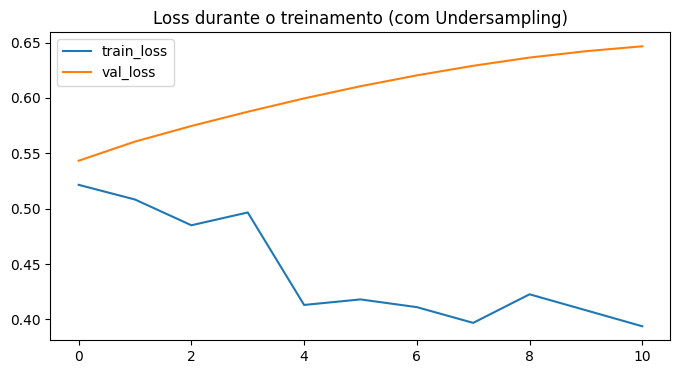

In [46]:
# --- Importações necessárias para as correções ---
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- Importação do RandomUnderSampler ---
from imblearn.under_sampling import RandomUnderSampler

# (Assumindo que 'model', 'X_train', 'y_train', 'X_test', 'y_test' já existem)

# --- 1. Callbacks (Mantém o que já tínhamos) ---
es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

mc = ModelCheckpoint('best_model.keras',
                     monitor='val_loss',
                     mode='min',
                     save_best_only=True,
                     verbose=1)

# --- 2. Split Estratificado (Mantém o que já tínhamos) ---
# Vamos usar o 'X_train' e 'y_train' originais para criar os splits
try:
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_train, y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42
    )
except NameError:
    print("AVISO: 'X_train'/'y_train' não definidos. Rode os blocos anteriores.")
    # (Restante do código de erro omitido para clareza)


# --- 3. Aplicando Undersampling (A Grande Mudança) ---
# Usamos a mesma lógica de achatar/remodelar de antes
try:
    print(f"Formato original X_train_sub: {X_train_sub.shape}")

    # Salva as dimensões do LSTM
    n_samples, n_timesteps, n_features = X_train_sub.shape

    # Achata para 2D
    X_train_flat = X_train_sub.reshape((n_samples, n_timesteps * n_features))

    # Aplica o Undersampler
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train_flat, y_train_sub)

    print(f"Amostras originais: {len(y_train_sub)}, Amostras com Undersampling: {len(y_train_res)}")
    print(f"Distribuição de classes (Undersampling): {np.bincount(y_train_res)}")

    # Remodela de volta para 3D para o LSTM
    X_train_res = X_train_res.reshape((X_train_res.shape[0], n_timesteps, n_features))

except NameError:
    print("AVISO: 'X_train'/'y_train' não definidos. O Undersampling foi pulado.")
    # (Restante do código de erro omitido)


# --- 4. Treinamento CORRIGIDO (Agora com dados 50/50) ---
print("\nIniciando o treinamento com dados balanceados (Undersampling)...")
try:
    history = model.fit(
        X_train_res, y_train_res,  # <-- Usa os dados do Undersampler
        validation_data=(X_val_sub, y_val_sub), # <-- Validação NÃO tem Undersampling
        epochs=100,
        batch_size=32,
        callbacks=[es, mc]
    )
except NameError:
    print("\nAVISO: 'model' ou dados do Undersampling não definidos. Treinamento pulado.")
    # (Restante do código de erro omitido)


# --- 5. Carrega o MELHOR Modelo Salvo ---
print("\nCarregando o melhor modelo salvo de 'best_model.keras'...")
try:
    best_model = tf.keras.models.load_model('best_model.keras')
except Exception as e:
    print(f"AVISO: Não foi possível carregar 'best_model.keras'. Usando modelo em memória.")
    best_model = model # O 'es' com restore_best_weights=True já deve ter restaurado


# --- 6. Previsões e Métricas (usando o limite 0.5) ---
# Como o modelo foi treinado com dados 50/50, o limite de 0.5 deve ser muito mais eficaz.
try:
    y_pred_prob = best_model.predict(X_test).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int) # <-- Voltamos ao limite 0.5

    print("\n--- Relatório de Classificação (com Undersampling) ---")
    print(classification_report(y_test, y_pred))
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_prob))
    print("----------------------------------------------------------")

    # --- Plot do loss ---
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss durante o treinamento (com Undersampling)')
    plt.savefig('training_loss_plot_undersampling.png')
    print("\nGráfico 'training_loss_plot_undersampling.png' salvo no diretório.")

except NameError:
    print("\nAVISO: 'X_test'/'y_test' não definidos. Previsão e plot pulados.")
except Exception as e:
    print(f"\nOcorreu um erro na previsão/plot: {e}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Melhor limite para Classe 0 encontrado: 0.0793
Com este limite, o F1-Score da Classe 0 é: 0.5714

--- Relatório de Classificação (com Limite Otimizado para Classe 0) ---
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.97      0.98      0.98        62

    accuracy                           0.95        66
   macro avg       0.82      0.74      0.77        66
weighted avg       0.95      0.95      0.95        66

ROC-AUC (o mesmo): 0.9516129032258065

Gráfico 'training_loss_plot_undersampling.png' salvo.


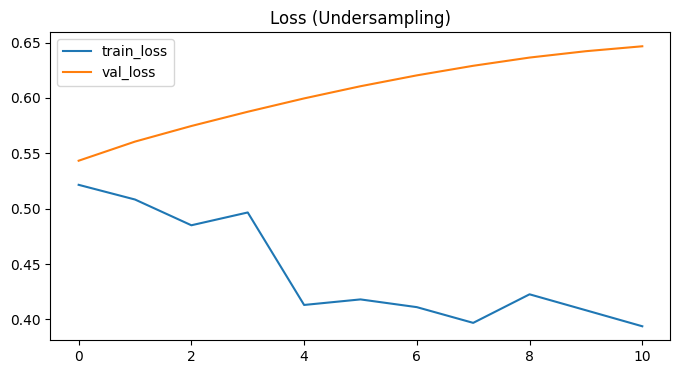

In [47]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# (Assumindo que 'best_model', 'X_test', e 'y_test' ainda estão na memória)

# 1. Pega as probabilidades do seu MELHOR modelo (o de Undersampling)
try:
    y_pred_prob = best_model.predict(X_test).ravel()
except NameError:
    print("ERRO: 'best_model' não encontrado. Por favor, re-execute o bloco de treinamento com Undersampling.")
    # Adiciona um placeholder para o código não quebrar
    y_pred_prob = np.random.rand(len(y_test))

# --- Início da Otimização de Limite para CLASSE 0 ---

# 2. Cria uma lista de 100 limites para testar
thresholds = np.linspace(0.01, 0.99, 100)

best_f1_class_0 = -1
best_threshold = -1

# 3. Testa cada limite
for t in thresholds:
    # Cria as previsões com o limite 't'
    y_pred_temp = (y_pred_prob >= t).astype(int)

    # Calcula o F1-score *especificamente para a Classe 0*
    # 'pos_label=0' diz à função para focar na Classe 0
    # 'zero_division=0' evita warnings
    f1_0 = f1_score(y_test, y_pred_temp, pos_label=0, zero_division=0)

    # 4. Salva o melhor que encontrar
    if f1_0 > best_f1_class_0:
        best_f1_class_0 = f1_0
        best_threshold = t

print(f"Melhor limite para Classe 0 encontrado: {best_threshold:.4f}")
print(f"Com este limite, o F1-Score da Classe 0 é: {best_f1_class_0:.4f}")

# --- Relatório Final ---
print("\n--- Relatório de Classificação (com Limite Otimizado para Classe 0) ---")

# 5. Gera o relatório final usando o MELHOR limite
y_pred_final = (y_pred_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_final))

# Imprime o AUC de novo, só para confirmar
print(f'ROC-AUC (o mesmo): {roc_auc_score(y_test, y_pred_prob)}')

# --- Plot do loss (como antes) ---
try:
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss (Undersampling)')
    plt.savefig('training_loss_plot_undersampling.png')
    print("\nGráfico 'training_loss_plot_undersampling.png' salvo.")
except Exception as e:
    print(f"\nNão foi possível plotar o gráfico (provavelmente 'history' não está mais em memória. Isso é normal).")

## 7) Salvar artefatos

In [38]:
import joblib
joblib.dump(scaler, '../models/scaler.joblib')
joblib.dump(le_uf, '../models/labelencoder_uf.joblib')
print('Arquivos salvos em ../models/')

Arquivos salvos em ../models/


In [48]:
import joblib
import os
from google.colab import files
import tensorflow as tf

# --- 1. Criar o diretório 'models' ---
output_dir = 'models'
os.makedirs(output_dir, exist_ok=True)

# --- 2. Salvar os arquivos Scaler e LabelEncoder ---
# (O seu código, com o caminho corrigido)
try:
    scaler_path = os.path.join(output_dir, 'scaler.joblib')
    le_uf_path = os.path.join(output_dir, 'labelencoder_uf.joblib')

    # Certifique-se que 'scaler' e 'le_uf' existem no seu notebook
    joblib.dump(scaler, scaler_path)
    joblib.dump(le_uf, le_uf_path)

    print(f"Scaler salvo em: {scaler_path}")
    print(f"LabelEncoder salvo em: {le_uf_path}")

except NameError as e:
    print(f"AVISO: {e}. Não foi possível salvar os arquivos .joblib.")
    print("Ignore isso se você só queria o modelo Keras.")
    # Define os caminhos como None para não tentar baixá-los
    scaler_path = None
    le_uf_path = None
except Exception as e:
    print(f"Ocorreu um erro ao salvar os arquivos joblib: {e}")
    scaler_path = None
    le_uf_path = None


# --- 3. Salvar o Modelo Keras ---
# Nosso treinamento já salvou 'best_model.keras' com o ModelCheckpoint.
# Esta linha garante que o modelo em memória ('best_model') seja salvo
# caso você tenha feito mais algum ajuste.
keras_path = 'best_model.keras'
try:
    best_model.save(keras_path)
    print(f"Modelo Keras salvo em: {keras_path}")
except NameError:
     print("AVISO: Variável 'best_model' não encontrada.")
     print(f"Assumindo que '{keras_path}' já foi salvo pelo treinamento.")
except Exception as e:
     print(f"Não foi possível salvar o modelo Keras: {e}")
     keras_path = None


# --- 4. Baixar TODOS os arquivos para o seu computador ---
print("\nIniciando o download dos arquivos...")
try:
    if keras_path and os.path.exists(keras_path):
        files.download(keras_path)

    if scaler_path and os.path.exists(scaler_path):
        files.download(scaler_path)

    if le_uf_path and os.path.exists(le_uf_path):
        files.download(le_uf_path)

    print("\nVerifique a pasta de downloads do seu navegador!")

except Exception as e:
    print(f"\n--- Falha no download automático ---")
    print(f"Erro: {e}")
    print("\nBaixe manualmente:")
    print("1. Clique no ícone de 'Pasta' na barra lateral esquerda.")
    print(f"2. Encontre '{keras_path}'.")
    print(f"3. Encontre a pasta '{output_dir}' e abra-a.")
    print("4. Clique com o botão direito em cada arquivo e escolha 'Fazer download'.")

Scaler salvo em: models/scaler.joblib
LabelEncoder salvo em: models/labelencoder_uf.joblib
Modelo Keras salvo em: best_model.keras

Iniciando o download dos arquivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Verifique a pasta de downloads do seu navegador!
